## GPT/Claude based Schematic component recognition

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "led_array.jpeg",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the image\n   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)\n   - A list of components present on this schematic drawing, including their name (like resistor, capacitor, switch etc), position on the image, and orientation (you may approaximate using pixel locations)\n   - A list of connections made by the components, you must make sure all the referneces stays consistent throught your answer!\n   Please just reply ONLY in JSON output and nothing else!\n   "
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "led_array.jpeg",
  "prompt": "\n   Given the image which 
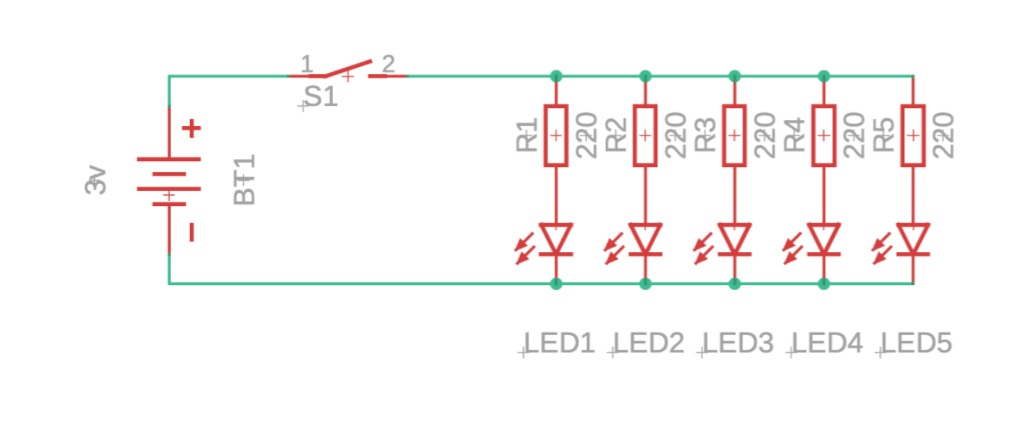

In [2]:
from LLMToSchematics import image_to_schematics

result= image_to_schematics("led_array.jpeg")

# GPT Output processing

In [73]:
# save the result

# save the result dictionary to a file
import json
with open('result.json', 'w') as f:
    json.dump(result, f, indent=4)




In [17]:
# load the dictionary from the file
import json
with open('result.json', 'r') as f:
    result = json.load(f)

In [3]:
# iterate through the list of dicts results and remove empty dicts
for i in range(len(result['detected_components'])):
    if not result['detected_components'][i]:
        del result['detected_components'][i]
for component in result["detected_components"]:
    print(component["lib_id"])

battery
switch_spst
resistor
resistor
resistor
resistor
resistor
led
led
led
led
led


In [20]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
list_of_component_dict =[]


for symbol in result["detected_components"]:
    print(symbol["lib_id"], symbol["x"], symbol["y"], symbol["angle"], symbol["reference"])
    
    # Add the component to the list
    list_of_component_dict.append({"lib_id": kicad_utils.match_libId(symbol["lib_id"]), "x": symbol["x"], "y": symbol["y"], "angle": symbol["angle"], "reference_name": symbol["reference"]})

print("List of component dictionaries:")
print(list_of_component_dict)
# Accepts a list of component dictionaries and a scaling factor
def scale_components(components, scaling_factor):
    # Find the minimum and maximum x and y coordinates
    min_x = min(component['x'] for component in components)
    max_x = max(component['x'] for component in components)
    min_y = min(component['y'] for component in components)
    max_y = max(component['y'] for component in components)
    
    # Scale the components
    scaled_components = []
    for component in components:
        scaled_x = min_x + (component['x'] - min_x) * scaling_factor
        scaled_y = min_y + (component['y'] - min_y) * scaling_factor
        scaled_component = component.copy()
        scaled_component['x'] = int(scaled_x)
        scaled_component['y'] = int(scaled_y)
        scaled_components.append(scaled_component)
    
    return scaled_components


scaled_components = scale_components(list_of_component_dict, 0.2)
print("Scaled Components:")
print(scaled_components)




BT1 20 45 90 BT1
S1 100 20 0 S1
R1 200 20 0 R1
R2 300 20 0 R2
R3 400 20 0 R3
R4 500 20 0 R4
R5 600 20 0 R5
LED1 200 70 90 LED1
LED2 300 70 90 LED2
LED3 400 70 90 LED3
LED4 500 70 90 LED4
List of component dictionaries:
[{'lib_id': 'BT1', 'x': 20, 'y': 45, 'angle': 90, 'reference_name': 'BT1'}, {'lib_id': 'S1', 'x': 100, 'y': 20, 'angle': 0, 'reference_name': 'S1'}, {'lib_id': 'R1', 'x': 200, 'y': 20, 'angle': 0, 'reference_name': 'R1'}, {'lib_id': 'R2', 'x': 300, 'y': 20, 'angle': 0, 'reference_name': 'R2'}, {'lib_id': 'R3', 'x': 400, 'y': 20, 'angle': 0, 'reference_name': 'R3'}, {'lib_id': 'R4', 'x': 500, 'y': 20, 'angle': 0, 'reference_name': 'R4'}, {'lib_id': 'R5', 'x': 600, 'y': 20, 'angle': 0, 'reference_name': 'R5'}, {'lib_id': 'LED1', 'x': 200, 'y': 70, 'angle': 90, 'reference_name': 'LED1'}, {'lib_id': 'LED2', 'x': 300, 'y': 70, 'angle': 90, 'reference_name': 'LED2'}, {'lib_id': 'LED3', 'x': 400, 'y': 70, 'angle': 90, 'reference_name': 'LED3'}, {'lib_id': 'LED4', 'x': 500, 'y':

In [12]:
import kicad_utils
kicad_utils.modify_kicad_sch_file(components = scaled_components, file_path=kicad_schematic_path)

Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "dea647a7-e0d8-45e4-9bce-23c7e387cf2b")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:Battery"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0) hide)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "BT"\n\t\t\t(at 2.54 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "Battery"\n\t\t\t(at 2.54 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0 1.524 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 1.524 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Descripti

In [50]:
# kicad_utils.modify_kicad_sch_file(wires= result['detected_wires'], file_path=kicad_schematic_path)

In [5]:
for connection in result["component_connections"]:
    print(connection['componentA_reference'], connection['componentA_pin'], connection['componentB_reference'], connection['componentB_pin'])

    

BAT1 1 R1 1
BAT1 2 LED1 2
R1 2 LED1 1


# THIS IS THE MOST IMPORTANT CELL

In [6]:
# result["component_connections"][0]['componentA_reference']
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []

for symbol in schem.symbol:
    print(symbol.property.Reference.value)
    


BAT1
LED1
R1


In [7]:
def find_component_in_schem(component_reference, skip_schematic):
    for symbol in skip_schematic.symbol:
        if symbol.property.Reference.value == component_reference:
            return symbol
found_symbol = find_component_in_schem("C1", schem)
print(found_symbol)
print(found_symbol.pin[0].location.x)

None


AttributeError: 'NoneType' object has no attribute 'pin'

In [13]:
# Pseudo code
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []


# make a copy of detected connections
all_connections = result["component_connections"].copy()

# Iterate through the list of generated components in kicad shematic
for curr_component in schem.symbol:
    print(curr_component.property.Reference.value)
    curr_component_ref = curr_component.property.Reference.value
#   iterate through the list of detected connections
    for curr_connection in all_connections:
        # if curr component is compA in curr connection
        if curr_connection['componentA_reference'] == curr_component_ref:
            curr_component_A_pin = curr_component.pin[curr_connection['componentA_pin']-1]
            #find component B
            curr_component_B = find_component_in_schem(curr_connection['componentB_reference'], schem)
            curr_component_B_pin = curr_component_B.pin[curr_connection['componentB_pin']-1]
            # add a wire to connect
            wire_list.append({"x": curr_component_A_pin.location.x, "y": curr_component_A_pin.location.y, "end_x": curr_component_B_pin.location.x, "end_y":curr_component_B_pin.location.y})

print("Wire List")


BAT1
LED1
R1
Wire List


In [14]:
print(wire_list)

def split_diagonal_segments(wire_list):
    new_wire_list = []
    for segment in wire_list:
        # Check if the segment is diagonal
        if segment['x'] != segment['end_x'] and segment['y'] != segment['end_y']:
            # Split the diagonal segment into horizontal and vertical segments
            horizontal_segment = {'x': segment['x'], 'y': segment['y'], 'end_x': segment['end_x'], 'end_y': segment['y']}
            vertical_segment = {'x': segment['end_x'], 'y': segment['y'], 'end_x': segment['end_x'], 'end_y': segment['end_y']}
            new_wire_list.append(horizontal_segment)
            new_wire_list.append(vertical_segment)
        else:
            new_wire_list.append(segment)  # Keep non-diagonal segments unchanged
    return new_wire_list


new_wire_list = split_diagonal_segments(wire_list)
print(new_wire_list)

[{'x': 25, 'y': 94.92, 'end_x': 58.81, 'end_y': 100}, {'x': 25, 'y': 105.08, 'end_x': 85, 'end_y': 96.19}, {'x': 51.19, 'y': 100, 'end_x': 85, 'end_y': 103.81}]
[{'x': 25, 'y': 94.92, 'end_x': 58.81, 'end_y': 94.92}, {'x': 58.81, 'y': 94.92, 'end_x': 58.81, 'end_y': 100}, {'x': 25, 'y': 105.08, 'end_x': 85, 'end_y': 105.08}, {'x': 85, 'y': 105.08, 'end_x': 85, 'end_y': 96.19}, {'x': 51.19, 'y': 100, 'end_x': 85, 'end_y': 100}, {'x': 85, 'y': 100, 'end_x': 85, 'end_y': 103.81}]


In [15]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
kicad_utils.modify_kicad_sch_file(wires= new_wire_list, file_path=kicad_schematic_path)

Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "dea647a7-e0d8-45e4-9bce-23c7e387cf2b")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:Battery"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0) hide)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "BT"\n\t\t\t(at 2.54 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "Battery"\n\t\t\t(at 2.54 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0 1.524 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 1.524 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Descripti

In [30]:
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []


print(schem.symbol[0].pin[0].location.x)

283.81


In [31]:
wire_list = []
wire_list.append({"x": 121.92, "y": 67.31, "end_x": 156.21, "end_y": 67.31})
wire_list.append({"x": 1221.92, "y": 672.31, "end_x": 156.21, "end_y": 67.31})

print(wire_list)

[{'x': 121.92, 'y': 67.31, 'end_x': 156.21, 'end_y': 67.31}, {'x': 1221.92, 'y': 672.31, 'end_x': 156.21, 'end_y': 67.31}]


In [32]:

for connection in result["component_connections"]:
    wire_list.append({"x":"", "y": 67.31, "end_x": 156.21, "end_y": 67.31})
    

for component in schem.symbol:
    print(component.pin[0].location.x)


283.81
96.19


In [33]:
import kicad_utils
temp_file_path = "testProject/testProject.kicad_sch"

temp_components = [
    # {"lib_id": ":SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    {"lib_id": "Device:R", "x": 146.05, "y": 53.34, "angle":90, "reference_name": "R1"}
]

# kicad_utils.extract_symbol_definition("Device:R")
# kicad_utils.modify_kicad_sch_file(components = temp_components, file_path=temp_file_path)
kicad_utils.create_kicad_sch_file(components = temp_components,)


Created file temp_7067e852-db20-4460-a3d6-16a41af6c8cd.kicad_sch


'temp_7067e852-db20-4460-a3d6-16a41af6c8cd.kicad_sch'

## Try adding wires


In [43]:
import skip


# load a schematic
schem = skip.Schematic("testProject/testProject.kicad_sch")
